# Fitting

In [ ]:
import sys
sys.path.insert(0, '../../src/')

import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import tensorflow as tf

from qiskit.quantum_info import Operator
from tqdm.notebook import tqdm

from kraus_channels import KrausMap, isomery_to_kraus
from loss_functions import ProbabilityMSE, ProbabilityRValue
from optimization import ModelSPAM, ModelQuantumMap, Logger, model_saver
from quantum_channel import channel_fidelity
from experimental import counts_to_probs, generate_pauliInput_circuits, generate_pauli_circuits, marginalize_counts
from spam import SPAM, InitialState, CorruptionMatrix
from utils import saver
from quantum_circuits import pqc_basic
from spectrum import channel_spectrum, complex_spacing_ratio
from quantum_circuits import integrable_circuit


#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
def integrable_circuit(n, L):
    theta_list = [np.random.uniform(-np.pi, np.pi, n) for i in range(L)]
    sqrt_iSWAP = iSwapGate().power(1 / 2)

    circuit = qk.QuantumCircuit(n)
    for i, theta in enumerate(theta_list):

        offset = i%2
        for j in range(n):
            circuit.rz(theta[j], j)

        for j in range((n - offset) // 2):
            circuit.append(sqrt_iSWAP, [2 * j + offset, 2 * j + 1 + offset])


    return circuit


def nonintegrable_circuit(n, L):
    theta_list = [np.random.uniform(-np.pi, np.pi, 2*n) for i in range(L)]
    sqrt_iSWAP = iSwapGate().power(1 / 2)

    circuit = qk.QuantumCircuit(n)
    for i, theta in enumerate(theta_list):

        offset = i%2
        for j in range(n):
            circuit.ry(theta[j], j)
            circuit.rz(theta[j+n], j)

        for j in range((n - offset) // 2):
            circuit.append(sqrt_iSWAP, [2 * j + offset, 2 * j + 1 + offset])


    return circuit

In [4]:
def load_data(filename, n, seed, L):
    with open(filename, 'rb') as f:
        data = pkl.load(f)


    data = marginalize_counts(data, 0)

    targets = counts_to_probs(data)
    targets_spam = targets[:6**n]
    targets_map = targets[6**n:]

    np.random.seed(seed)
    
    circuit_target = integrable_circuit(n+1, L)
    unitary = Operator(circuit_target).data

    inputs_spam, _ = generate_pauliInput_circuits(n)
        
    inputs_map, circuit_list_map = (
                generate_pauli_circuits(n, None, N=5000-6**n)
        )
    
    return inputs_spam, targets_spam, inputs_map, targets_map, unitary

def fit_spam(inputs, 
             targets,
             num_iter = 3000,
             verbose = False):
    d = targets.shape[1]
    spam_model = SPAM(init = InitialState(d),
                    povm = CorruptionMatrix(d),
                    )

    spam_opt = ModelSPAM(spam_model, tf.keras.optimizers.Adam(learning_rate=0.01))
        
    spam_opt.pretrain(100, verbose=False)

    spam_opt.train(inputs = inputs,
                    targets = targets,
                    num_iter = num_iter,
                    verbose = verbose,
                )
    
    return spam_model
    

def fit_model(inputs, 
              targets, 
              spam_model,
              num_iter = 3000,
              verbose=False):
    d = targets.shape[1]
    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                        rank = d**2,
                                        spam = spam_model,
                                        ),
                    loss_function = ProbabilityMSE(),
                    optimizer = tf.optimizers.Adam(learning_rate=0.01),
                    logger = Logger(loss_function_list = [ProbabilityRValue()], sample_freq=100),
                )

    model.train(inputs = inputs,
                targets = targets,
                inputs_val = [inputs],
                targets_val = [targets],
                num_iter = num_iter,
                N = 500,
                verbose=verbose
                )
    
    return model

In [ ]:
path = 'data/chaos_exp_reorder/5q/integrable_L=50/'
# path = 'data/integrable_L=50/'
n = 4
d = 2**n
L=50

spam_list = []
model_list = []

for i in tqdm(range(10)):
    seed = 42 + i
    inputs_spam, targets_spam, inputs_map, targets_map, unitary = load_data(path + f'seed_{seed}.pkl', n, seed, L)
    spam_model = fit_spam(inputs_spam, targets_spam, verbose=True)
    spam_list.append(spam_model) 

    model = fit_model(inputs_map, 
                     targets_map, 
                     spam_model, 
                     verbose=True)
    model_list.append(model)

model_saver(spam_list, f'models/integrable_spam_{n}_L=50_reorder.model')
model_saver(model_list, f'models/integrable_model_{n}_L=50_reorder.model')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3000 [00:00<?, ?it/s]

0.05832540086890092 
0.004893233817868755 
0.0004096385122271298 
7.729505324155442e-05 
7.551944426766799e-05 
7.423116614401013e-05 
7.335591768006234e-05 
7.271530484636556e-05 
7.22282641265686e-05 
7.18415877350677e-05 
7.155372583020446e-05 
7.134326812249695e-05 
7.118547549703117e-05 
7.104316475341534e-05 
7.093193544888569e-05 
7.085667867307049e-05 
7.079087784775669e-05 
7.069962913838341e-05 
7.064496367219662e-05 
7.062519375319374e-05 
7.056553936886348e-05 
7.054045605239988e-05 
7.049943866465335e-05 
7.047912716563717e-05 
7.045362171914025e-05 
7.043982619218488e-05 


## Retrieve CSR

### L = 50

In [5]:
n = 4

model_list = pkl.load(open(f'models/integrable_model_{n}_L=50_reorder.model', 'rb'))

loss_list = []
spectrum_list = []
csr_integrable_list = []
for model in model_list:
    loss = model.logger.loss_list[0][-1]
    loss_list.append(loss)

    channel = model.channel
    spectrum = channel_spectrum(channel)

    csr = complex_spacing_ratio(spectrum)

    spectrum_list.append(spectrum)
    csr_integrable_list.append(csr)

csr_integrable = Spectrum(csr_integrable_list)

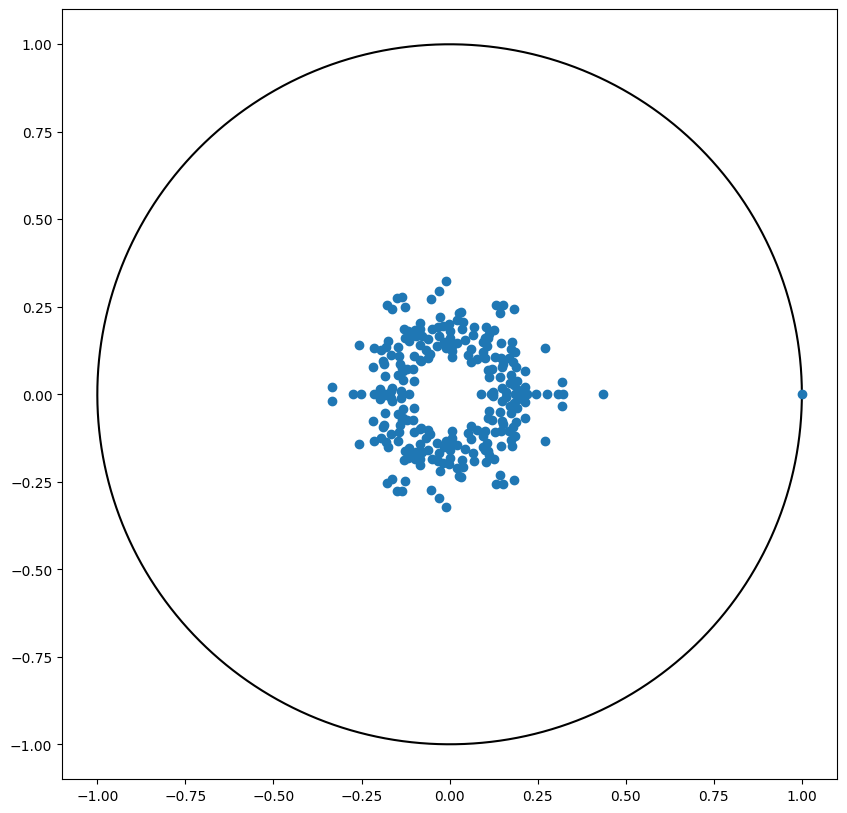

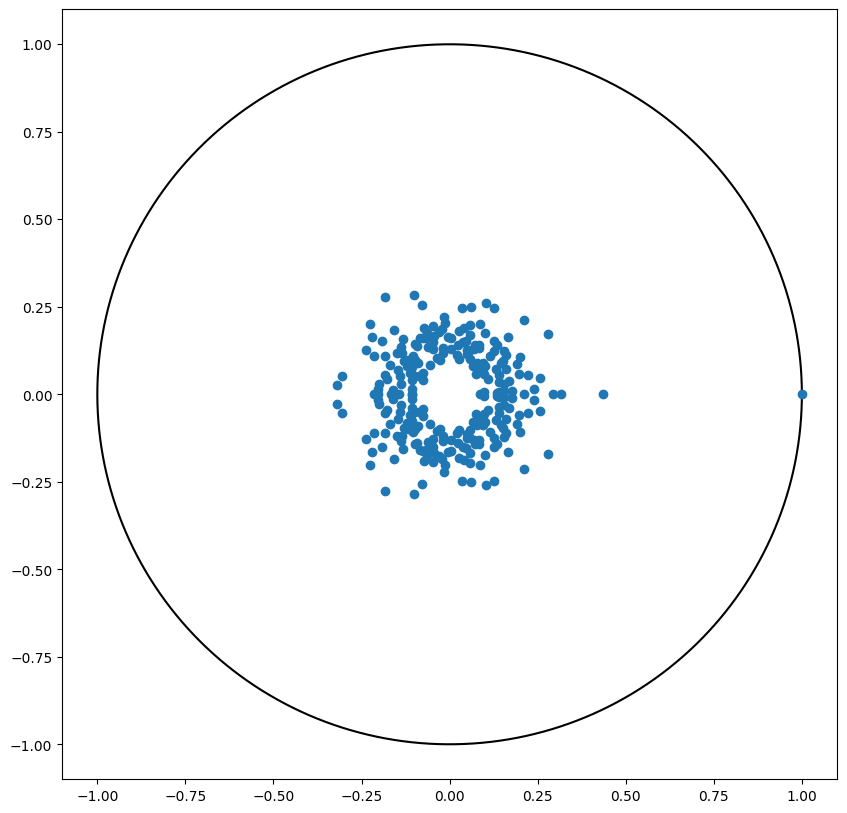

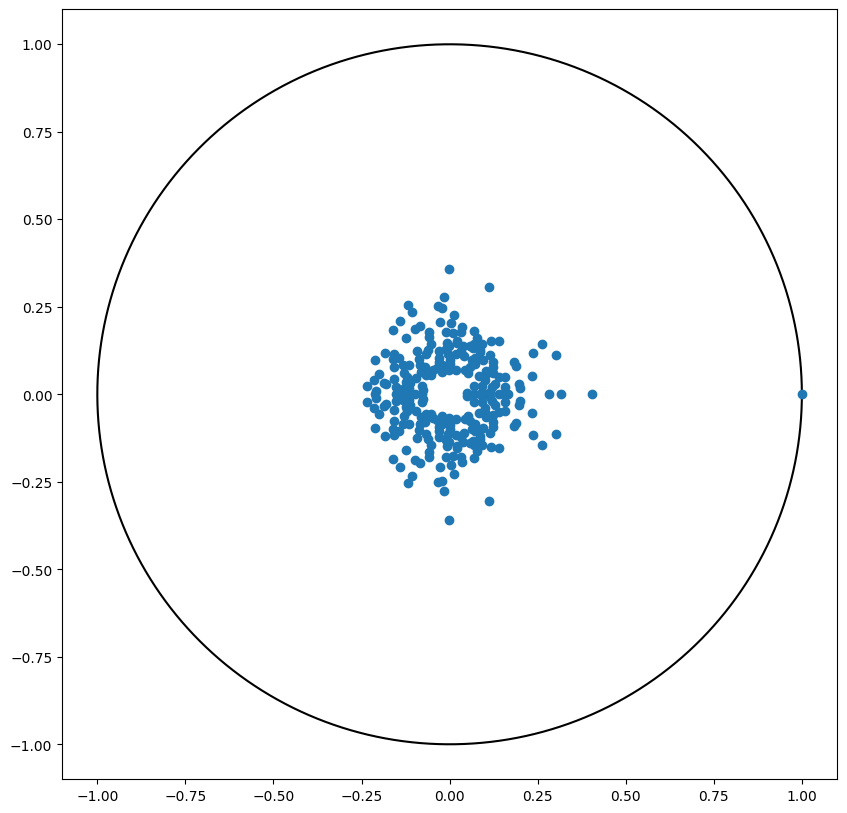

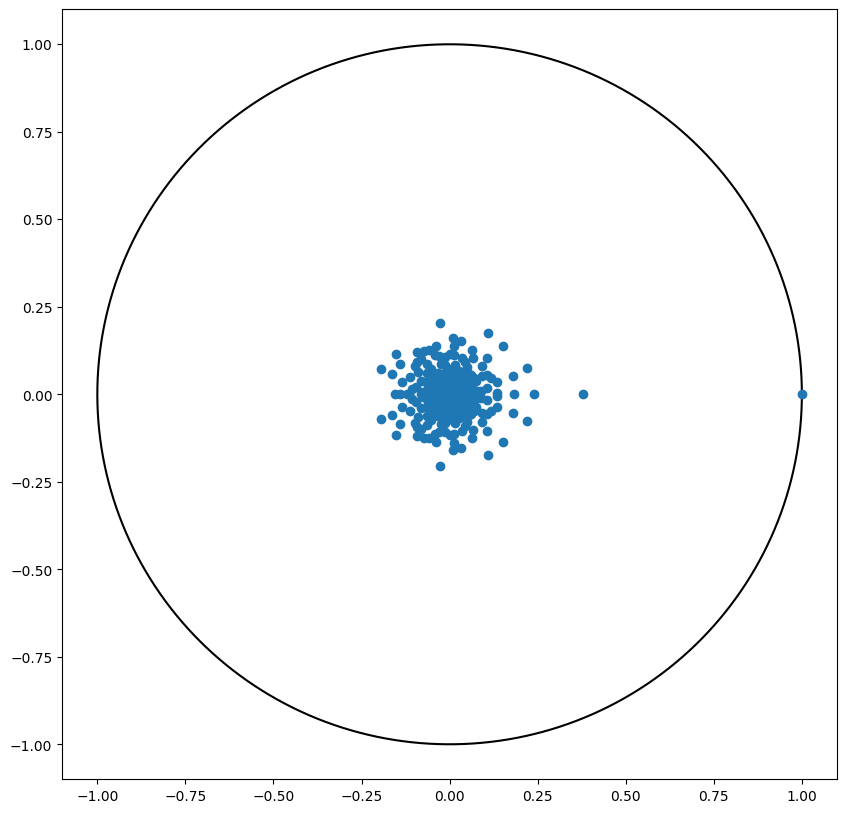

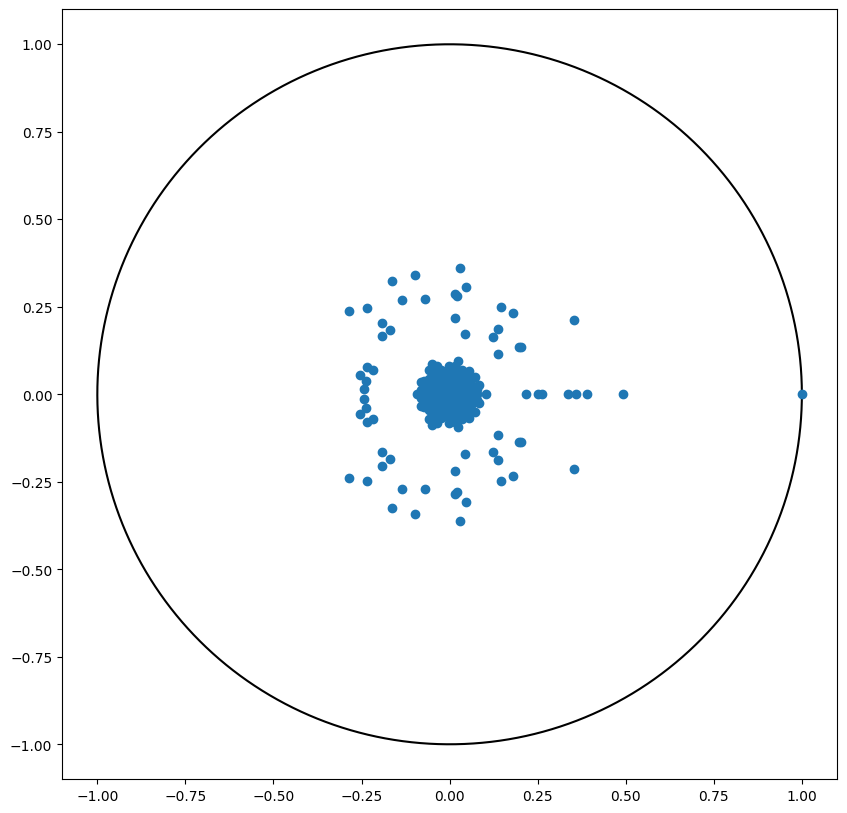

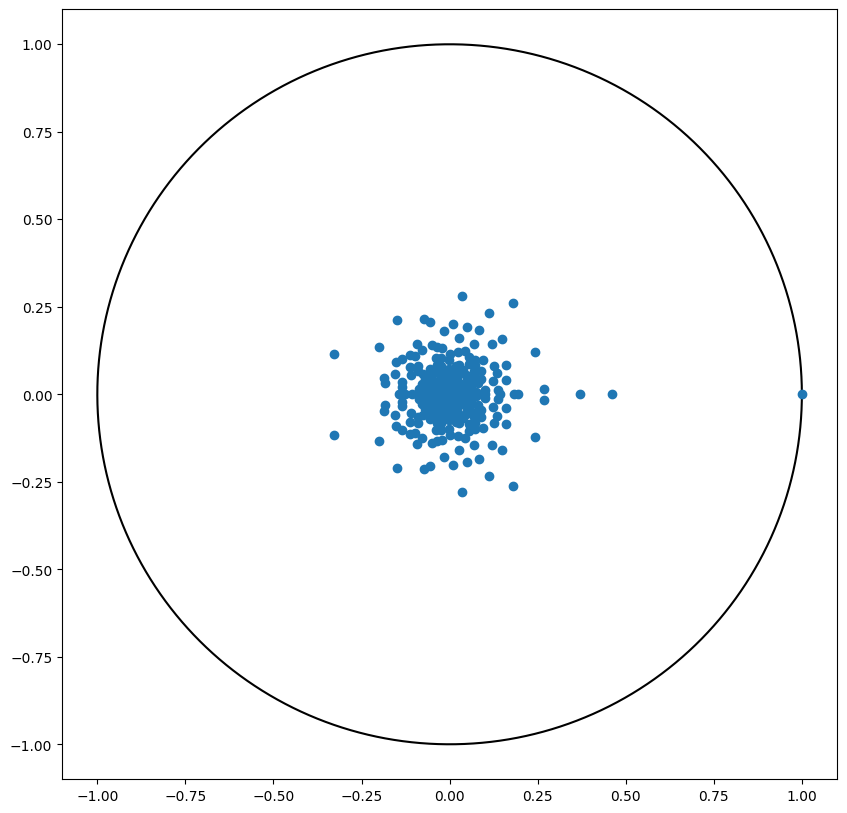

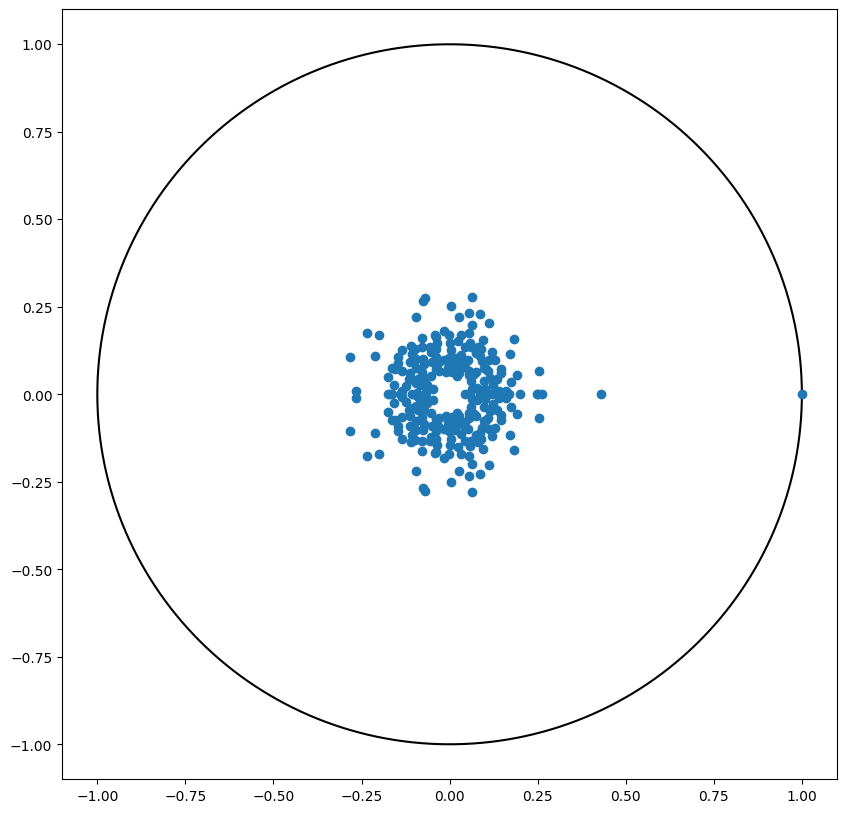

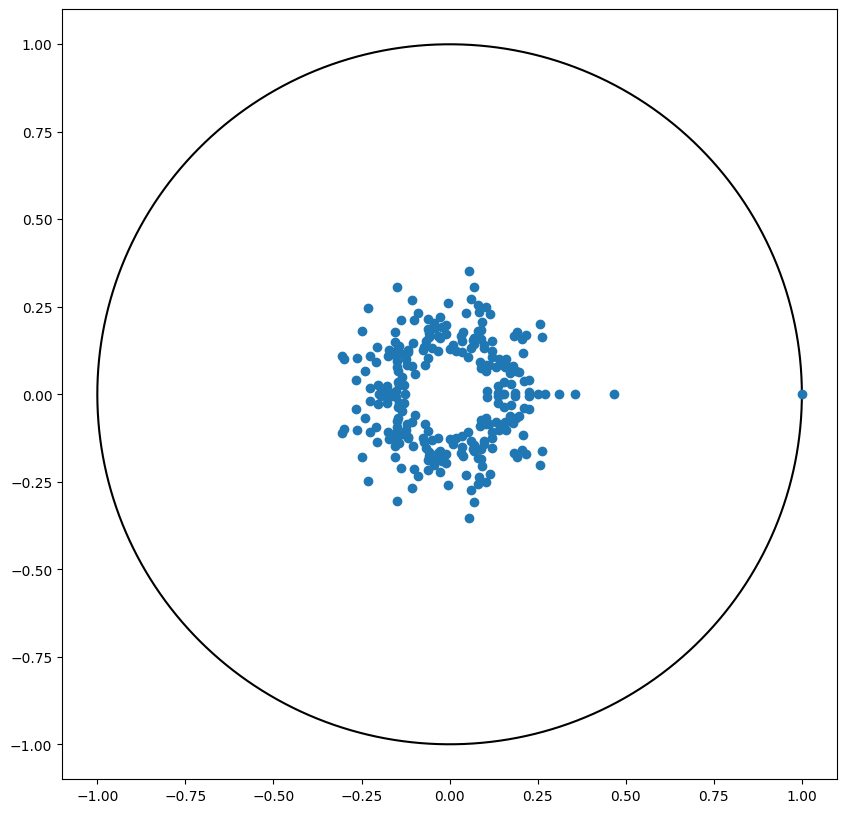

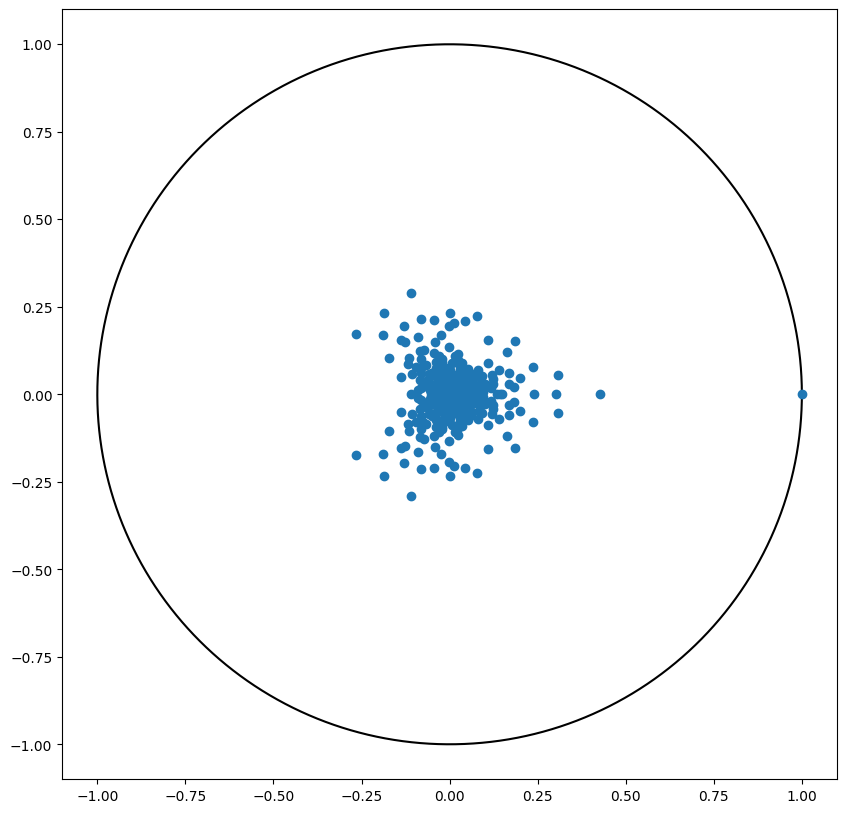

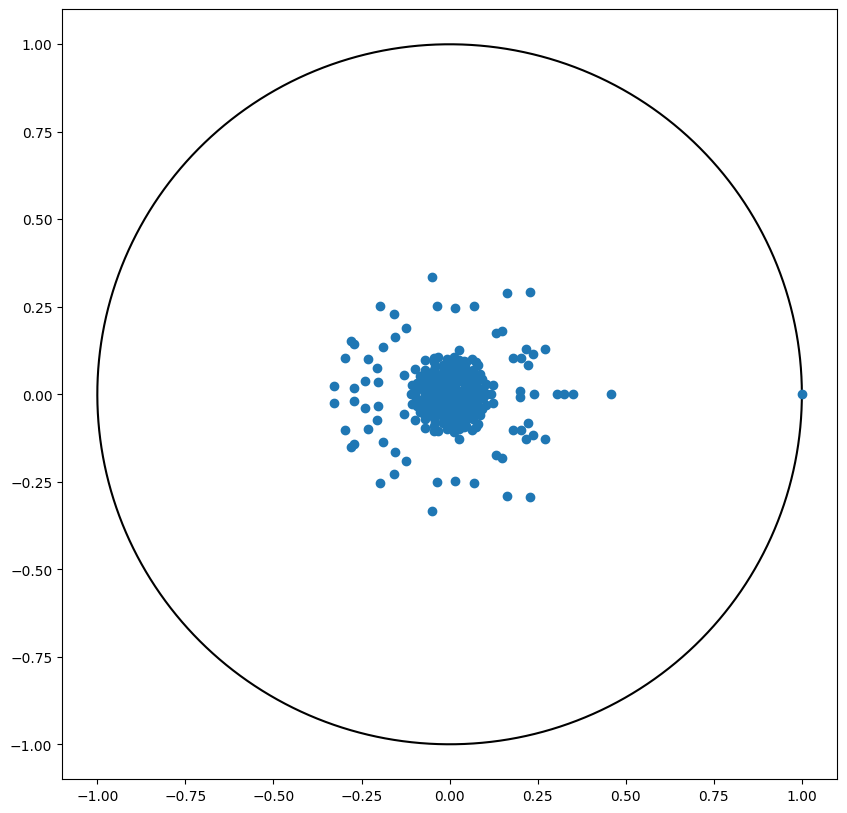

In [6]:
for spectrum in spectrum_list:
    spectrum.plot_circle()
    spectrum.plot()
    plt.show()

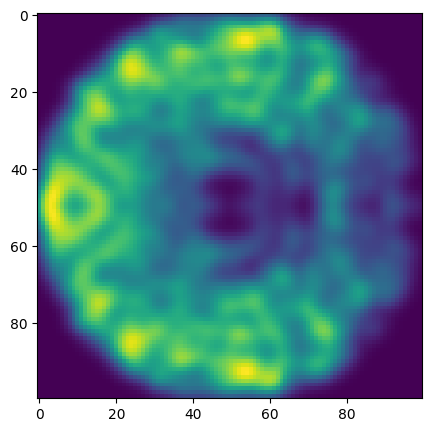

In [7]:
csr_integrable_coat = coat_spectrum(csr_integrable, sigma = 0.05)

fig = plt.figure(figsize=(5, 5))
fig.tight_layout()
plt.imshow(csr_integrable_coat)
plt.savefig('figures/integrable_crs_retrieved_L=50.png')
plt.show()

In [8]:
loss_mean = np.mean(loss_list)
loss_std = np.std(loss_list)

print(f'Loss mean: {loss_mean}, Loss std: {loss_std}')

Loss mean: 0.9826520331150904, Loss std: 0.0051503455069767
